<a href="https://colab.research.google.com/github/rafaelmessias/sampling_tsne/blob/master/Sampling_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
from time import time
import numpy as np
from scipy import linalg
import scipy.sparse as sp
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import _utils
from sklearn.manifold.t_sne import _barnes_hut_tsne
from sklearn import datasets
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import KNeighborsRegressor
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt

Please ignore the following cell, I had to modify a couple of sklearn's methods to do what I wanted to do in the rest of the notebook.

In [0]:
import sklearn
from sklearn.manifold.t_sne import _utils, MACHINE_EPSILON


def _joint_probabilities(distances, desired_perplexity, verbose):
    """Compute joint probabilities p_ij from distances.

    Parameters
    ----------
    distances : array, shape (n_samples * (n_samples-1) / 2,)
        Distances of samples are stored as condensed matrices, i.e.
        we omit the diagonal and duplicate entries and store everything
        in a one-dimensional array.

    desired_perplexity : float
        Desired perplexity of the joint probability distributions.

    verbose : int
        Verbosity level.

    Returns
    -------
    P : array, shape (n_samples * (n_samples-1) / 2,)
        Condensed joint probability matrix.
    """
    # Compute conditional probabilities such that they approximately match
    # the desired perplexity
    distances = distances.astype(np.float32, copy=False)
    conditional_P = _utils._binary_search_perplexity(
        distances, None, desired_perplexity, verbose)
    P = conditional_P + conditional_P.T
    sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
    P = np.maximum(squareform(P) / sum_P, MACHINE_EPSILON)
    return P, conditional_P

def _fit(self, X, skip_num_points=0, transform=True):
        """Fit the model using X as training data.

        Note that sparse arrays can only be handled by method='exact'.
        It is recommended that you convert your sparse array to dense
        (e.g. `X.toarray()`) if it fits in memory, or otherwise using a
        dimensionality reduction technique (e.g. TruncatedSVD).

        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            If the metric is 'precomputed' X must be a square distance
            matrix. Otherwise it contains a sample per row. Note that this
            when method='barnes_hut', X cannot be a sparse array and if need be
            will be converted to a 32 bit float array. Method='exact' allows
            sparse arrays and 64bit floating point inputs.

        skip_num_points : int (optional, default:0)
            This does not compute the gradient for points with indices below
            `skip_num_points`. This is useful when computing transforms of new
            data where you'd like to keep the old data fixed.
        """
        if self.method not in ['barnes_hut', 'exact']:
            raise ValueError("'method' must be 'barnes_hut' or 'exact'")
        if self.angle < 0.0 or self.angle > 1.0:
            raise ValueError("'angle' must be between 0.0 - 1.0")
        if self.metric == "precomputed":
            if isinstance(self.init, str) and self.init == 'pca':
                raise ValueError("The parameter init=\"pca\" cannot be "
                                 "used with metric=\"precomputed\".")
            if X.shape[0] != X.shape[1]:
                raise ValueError("X should be a square distance matrix")
            if np.any(X < 0):
                raise ValueError("All distances should be positive, the "
                                 "precomputed distances given as X is not "
                                 "correct")
        if self.method == 'barnes_hut' and sp.issparse(X):
            raise TypeError('A sparse matrix was passed, but dense '
                            'data is required for method="barnes_hut". Use '
                            'X.toarray() to convert to a dense numpy array if '
                            'the array is small enough for it to fit in '
                            'memory. Otherwise consider dimensionality '
                            'reduction techniques (e.g. TruncatedSVD)')
        if self.method == 'barnes_hut':
            X = check_array(X, ensure_min_samples=2,
                            dtype=[np.float32, np.float64])
        else:
            X = check_array(X, accept_sparse=['csr', 'csc', 'coo'],
                            dtype=[np.float32, np.float64])
        if self.method == 'barnes_hut' and self.n_components > 3:
            raise ValueError("'n_components' should be inferior to 4 for the "
                             "barnes_hut algorithm as it relies on "
                             "quad-tree or oct-tree.")
        random_state = check_random_state(self.random_state)

        if self.early_exaggeration < 1.0:
            raise ValueError("early_exaggeration must be at least 1, but is {}"
                             .format(self.early_exaggeration))

        if self.n_iter < 250:
            raise ValueError("n_iter should be at least 250")

        n_samples = X.shape[0]

        neighbors_nn = None
        if self.method == "exact":
            # Retrieve the distance matrix, either using the precomputed one or
            # computing it.
            if self.metric == "precomputed":
                distances = X
            else:
                if self.verbose:
                    print("[t-SNE] Computing pairwise distances...")

                if self.metric == "euclidean":
                    distances = pairwise_distances(X, metric=self.metric,
                                                   squared=True)
                else:
                    distances = pairwise_distances(X, metric=self.metric)

                if np.any(distances < 0):
                    raise ValueError("All distances should be positive, the "
                                     "metric given is not correct")

            # compute the joint probability distribution for the input space
            P, cond_P = _joint_probabilities(distances, self.perplexity, self.verbose)
            self.cond_P = cond_P
            self.P = P
            assert np.all(np.isfinite(P)), "All probabilities should be finite"
            assert np.all(P >= 0), "All probabilities should be non-negative"
            assert np.all(P <= 1), ("All probabilities should be less "
                                    "or then equal to one")

        else:
            # Cpmpute the number of nearest neighbors to find.
            # LvdM uses 3 * perplexity as the number of neighbors.
            # In the event that we have very small # of points
            # set the neighbors to n - 1.
            k = min(n_samples - 1, int(3. * self.perplexity + 1))

            if self.verbose:
                print("[t-SNE] Computing {} nearest neighbors...".format(k))

            # Find the nearest neighbors for every point
            knn = NearestNeighbors(algorithm='auto', n_neighbors=k,
                                   metric=self.metric)
            t0 = time()
            knn.fit(X)
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Indexed {} samples in {:.3f}s...".format(
                    n_samples, duration))

            t0 = time()
            distances_nn, neighbors_nn = knn.kneighbors(
                None, n_neighbors=k)
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Computed neighbors for {} samples in {:.3f}s..."
                      .format(n_samples, duration))

            # Free the memory used by the ball_tree
            del knn

            if self.metric == "euclidean":
                # knn return the euclidean distance but we need it squared
                # to be consistent with the 'exact' method. Note that the
                # the method was derived using the euclidean method as in the
                # input space. Not sure of the implication of using a different
                # metric.
                distances_nn **= 2

            # compute the joint probability distribution for the input space
            P = _joint_probabilities_nn(distances_nn, neighbors_nn,
                                        self.perplexity, self.verbose)

        if isinstance(self.init, np.ndarray):
            X_embedded = self.init
        elif self.init == 'pca':
            pca = PCA(n_components=self.n_components, svd_solver='randomized',
                      random_state=random_state)
            X_embedded = pca.fit_transform(X).astype(np.float32, copy=False)
        elif self.init == 'random':
            # The embedding is initialized with iid samples from Gaussians with
            # standard deviation 1e-4.
            X_embedded = 1e-4 * random_state.randn(
                n_samples, self.n_components).astype(np.float32)
        else:
            raise ValueError("'init' must be 'pca', 'random', or "
                             "a numpy array")

        # Degrees of freedom of the Student's t-distribution. The suggestion
        # degrees_of_freedom = n_components - 1 comes from
        # "Learning a Parametric Embedding by Preserving Local Structure"
        # Laurens van der Maaten, 2009.
        degrees_of_freedom = max(self.n_components - 1, 1)

        if transform:
            return self._tsne(P, degrees_of_freedom, n_samples,
                          X_embedded=X_embedded,
                          neighbors=neighbors_nn,
                          skip_num_points=skip_num_points)
          
sklearn.manifold.t_sne._joint_probabilities = _joint_probabilities
TSNE._fit = _fit

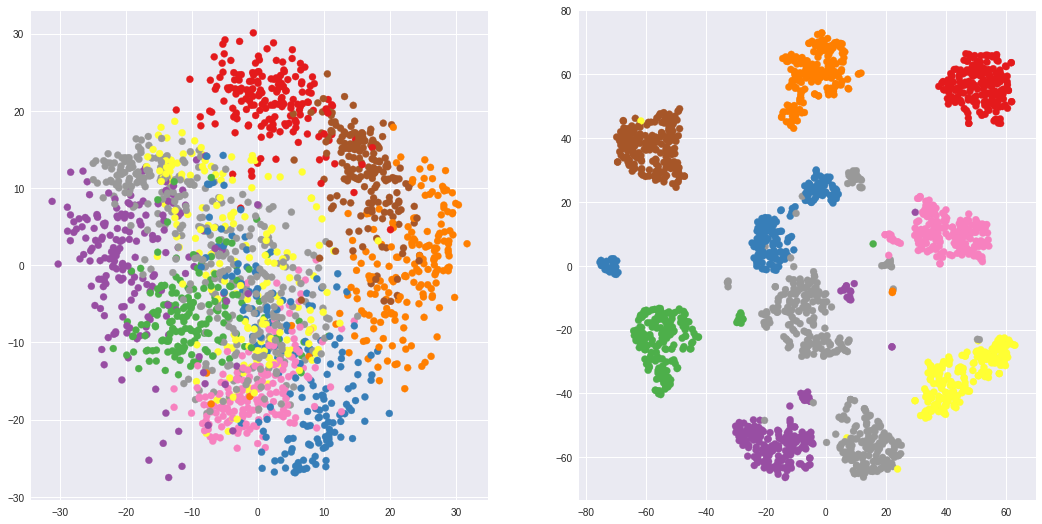

In [0]:
np.random.seed(12345)
    
# n, N = 900, 10
# X, y = make_blobs(n_samples=n, n_features=N)

# d = datasets.load_iris()
d = datasets.load_digits()
X, y = d.data, d.target
n, N = X.shape

proj_PCA = PCA(n_components=2).fit_transform(X)

model = TSNE(perplexity=30, method="exact", init="random")
# model._fit(X, transform=False)
proj_TSNE = model.fit_transform(X)

plt.figure(figsize=(18,9))
plt.subplot(121)
plt.scatter(*proj_PCA.T, c=y, cmap="Set1")
plt.subplot(122)
plt.scatter(*proj_TSNE.T, c=y, cmap="Set1")
plt.show()

Should be ~ 1.0: 1.0004933753006353


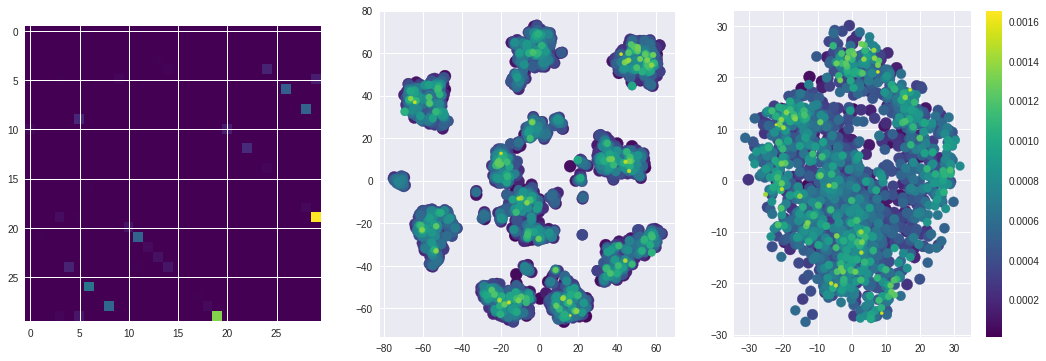

In [0]:
cond_P = model.cond_P
P = squareform(model.P)

P_j = cond_P.mean(axis=0)0

print("Should be ~ 1.0:", P_j.sum())

# Just for better visualization
sort_idx = np.argsort(P_j)
sort_P_j = P_j[sort_idx]
sort_proj_TSNE = proj_TSNE[sort_idx]
sort_proj_PCA = proj_PCA[sort_idx]
size = 300 - (((sort_P_j - sort_P_j.min()) / (sort_P_j.max() - sort_P_j.min())) * 150 + 150)

plt.figure(figsize=(18,6))

plt.subplot(131)
plt.imshow(cond_P[:30, :30], cmap="viridis")

plt.subplot(132)
plt.scatter(*sort_proj_TSNE.T, c=sort_P_j, s=size, cmap="viridis")

plt.subplot(133)
plt.scatter(*sort_proj_PCA.T, c=sort_P_j, s=size, cmap="viridis")

plt.colorbar()
plt.show()

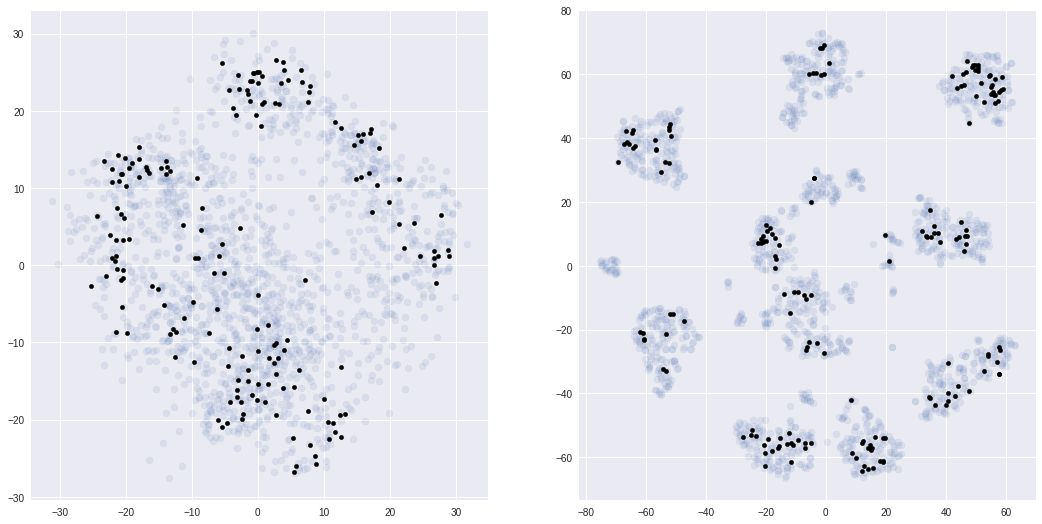

In [0]:
# n_s = int(np.sqrt(n))
n_s = n // 10

# Sampled by probability
sorted_P_j = np.argsort(P_j)
sampled, not_sampled = sorted_P_j[-n_s:], sorted_P_j[:-n_s]

X_s, y_s = X[sampled], y[sampled]
X_ns, y_ns = X[not_sampled], y[not_sampled]
P_s = P[sampled][:,sampled]
P_ns = P[not_sampled][:,sampled]

plt.figure(figsize=(18,9))

plt.subplot(121)
plt.scatter(*proj_PCA[not_sampled].T, alpha=0.1)
plt.scatter(*proj_PCA[sampled].T, c="k", s=20)

plt.subplot(122)
plt.scatter(*proj_TSNE[not_sampled].T, alpha=0.1)
plt.scatter(*proj_TSNE[sampled].T, c="k", s=20)

# plt.colorbar()
plt.show()

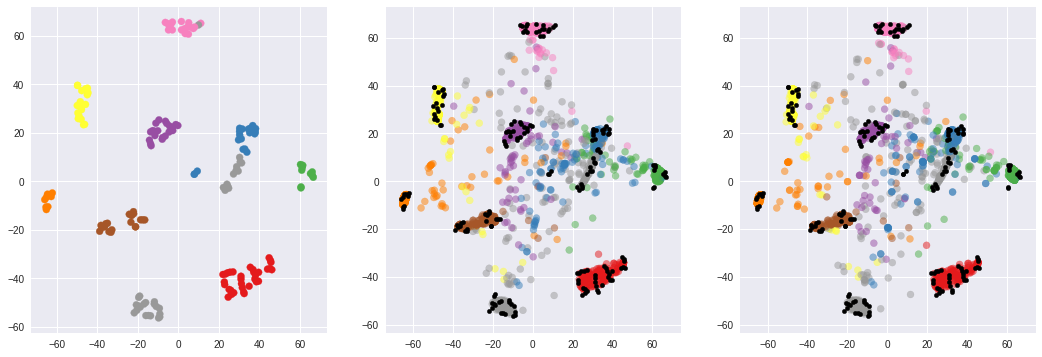

In [0]:
np.random.seed(12345)

model = TSNE(perplexity=5, method="exact", init="random")
proj_s = model.fit_transform(X_s)

# Normal KNN regression
knnr = KNeighborsRegressor(n_neighbors=5, weights="distance")
knnr.fit(X_s, proj_s)
proj_ns = knnr.predict(X_ns)

# Use probabilities as precomputed distance
knnr_p = KNeighborsRegressor(n_neighbors=5, metric="precomputed")
knnr_p.fit(1.0/(P_s + 0.0000001), proj_s)
proj_ns_p = knnr_p.predict(1.0/(P_ns + 0.0000001))


plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.scatter(*proj_s.T, c=y_s, cmap="Set1")

plt.subplot(132)
plt.scatter(*proj_ns.T, c=y_ns, cmap="Set1", alpha=0.5)
plt.scatter(*proj_s.T, c="k", s=20)

plt.subplot(133)
plt.scatter(*proj_ns_p.T, c=y_ns, cmap="Set1", alpha=0.5)
plt.scatter(*proj_s.T, c="k", s=20)


plt.show()

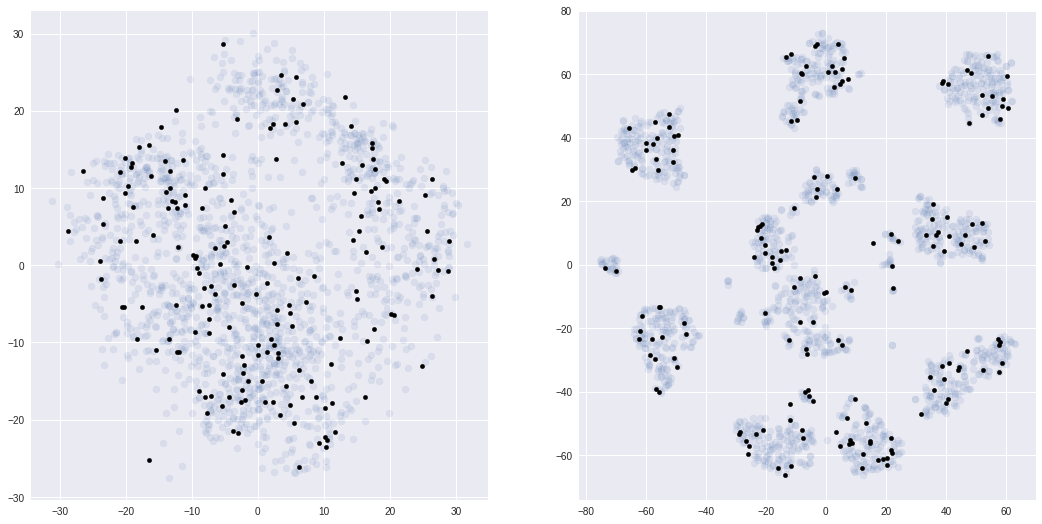

In [0]:
# n_s = int(np.sqrt(n))
n_s = n // 10

# Sampled randomly
sorted_P_j = np.arange(X.shape[0])
np.random.shuffle(sorted_P_j)
sampled, not_sampled = sorted_P_j[-n_s:], sorted_P_j[:-n_s]

X_s, y_s = X[sampled], y[sampled]
X_ns, y_ns = X[not_sampled], y[not_sampled]
P_s = P[sampled][:,sampled]
P_ns = P[not_sampled][:,sampled]

plt.figure(figsize=(18,9))

plt.subplot(121)
plt.scatter(*proj_PCA[not_sampled].T, alpha=0.1)
plt.scatter(*proj_PCA[sampled].T, c="k", s=20)

plt.subplot(122)
plt.scatter(*proj_TSNE[not_sampled].T, alpha=0.1)
plt.scatter(*proj_TSNE[sampled].T, c="k", s=20)

# plt.colorbar()
plt.show()

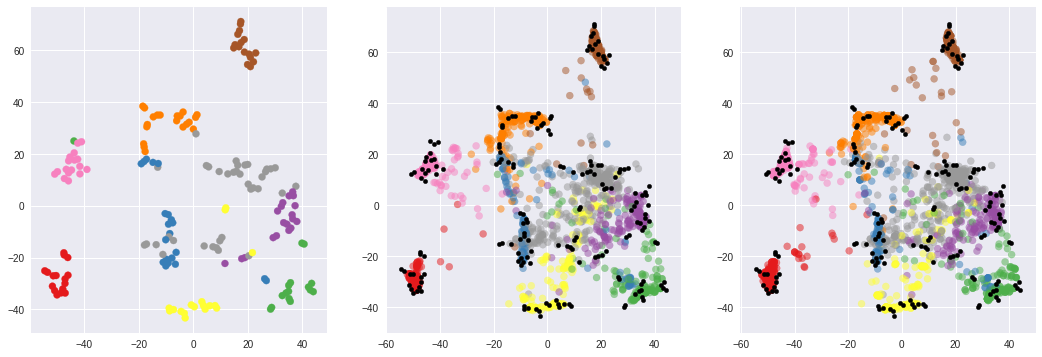

In [0]:
np.random.seed(12345)

model = TSNE(perplexity=5, method="exact", init="random")
proj_s = model.fit_transform(X_s)

# Normal KNN regression
knnr = KNeighborsRegressor(n_neighbors=5, weights="distance")
knnr.fit(X_s, proj_s)
proj_ns = knnr.predict(X_ns)

# Use probabilities as precomputed distance
knnr_p = KNeighborsRegressor(n_neighbors=5, metric="precomputed")
knnr_p.fit(1.0/(P_s + 0.0000001), proj_s)
proj_ns_p = knnr_p.predict(1.0/(P_ns + 0.0000001))


plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.scatter(*proj_s.T, c=y_s, cmap="Set1")

plt.subplot(132)
plt.scatter(*proj_ns.T, c=y_ns, cmap="Set1", alpha=0.5)
plt.scatter(*proj_s.T, c="k", s=20)

plt.subplot(133)
plt.scatter(*proj_ns_p.T, c=y_ns, cmap="Set1", alpha=0.5)
plt.scatter(*proj_s.T, c="k", s=20)


plt.show()